# Bank Marketing Prediction

This project focuses on utilizing machine learning techniques to predict the effectiveness of bank marketing campaigns. The data used in the project is provided by a Portuguese banking institution and includes input variables such as age, job, marital status, education, and balance etc.

The goal of this project is to develop a classification model that can accurately predict the effectiveness of bank marketing campaigns. Through the use of machine learning algorithms and techniques, the model will be able to classify a client's response to a campaign as either positive or negative. This project will provide insight into how different input variables can affect the effectiveness of bank marketing campaigns and help banks better target their customers. The data set contained details about bank marketing campaigns. Descriptive statistics were computed for each variable as part of the analysis, and visualizations were made to investigate the relationships between the target variable and other variable.

There are 45211 observations in this dataset and 17 columns with the following names: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, and y (target variable). There are no duplicate values in this dataset. The 10 categorical variables in this dataset are: employment, marital, education, default, housing, loan, contact, month, poutcome, and y. This dataset contains seven numerical variables: age, balance, day, duration, campaign, pdays, and prior. For the variables job, education, contact, and poutcome, the number of unknown tagged values are 288; 1857; 13020; and 36959, respectively.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report,  confusion_matrix, roc_curve, auc,  make_scorer, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Get Data

## Import csv file

In [3]:
df = pd.read_csv('dataset/Bank Marketing.csv')

## Data cleanup

In [4]:
df['job'] = df['job'].str.title()
df['marital'] = df['marital'].str.title()
df['education'] = df['education'].str.title()
df['default'] = df['default'].str.title()
df['housing'] = df['housing'].str.title()
df['loan'] = df['loan'].str.title()
df['contact'] = df['contact'].str.title()
df['month'] = df['month'].str.title()
df['poutcome'] = df['poutcome'].str.title()
df['y'] = df['y'].str.title()
df['y'] = df['y'].map({'Yes': 1, 'No': 0})

In [5]:
# Create duration bins
df['duration_bins'] = pd.cut(df['duration'], bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')])

In [6]:
df['job'] = df['job'].str.replace('.', '')
df['job'] = df['job'].str.strip()

In [7]:
df['poutcome'].value_counts()

poutcome
Failure    4901
Other      1840
Success    1511
Name: count, dtype: int64

# Explore the Data

## Quick glance at the data

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,duration_bins
0,58,Management,Married,Tertiary,No,2143,Yes,No,NaN,5,May,261,1,-1,0,NaN,0,"(200.0, 300.0]"
1,44,Technician,Single,Secondary,No,29,Yes,No,NaN,5,May,151,1,-1,0,NaN,0,"(100.0, 200.0]"
2,33,Entrepreneur,Married,Secondary,No,2,Yes,Yes,NaN,5,May,76,1,-1,0,NaN,0,"(0.0, 100.0]"
3,47,Blue-Collar,Married,NaN,No,1506,Yes,No,NaN,5,May,92,1,-1,0,NaN,0,"(0.0, 100.0]"
4,33,NaN,Single,NaN,No,1,No,No,NaN,5,May,198,1,-1,0,NaN,0,"(100.0, 200.0]"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [6]:
df.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [7]:
df.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

# Bivariate Analysis with target variable

In [8]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [9]:
# Function to create horizontal stacked bar plots with value labels and adjusted legend position
def plot_stacked_bar_horizontal(data, feature, target='y', palette='viridis'):
    # Calculate the counts for each category in the feature
    counts = data.groupby([feature, target]).size().unstack().fillna(0)
    
    # Normalize the counts to get proportions
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot
    ax = proportions.plot(kind='barh', stacked=True, figsize=(10, 4), colormap=palette, width=0.8)
    plt.title(f'Subscription Rate by {feature}')
    plt.xlabel('Subscription Rate')
    plt.ylabel(feature)
    plt.legend(title='target', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create the 'images' directory if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')
    
    # Save the plot as an image file
    plt.savefig(f'images/{feature}_subscription_rate.png', bbox_inches='tight')
    plt.show()

In [24]:
def plot_histogram(data, feature, target='y', palette='viridis'):
    plt.figure(figsize=(5, 6))
    sns.histplot(data=data, x=feature, hue=target, multiple='stack', palette=palette, kde=True)
    plt.title(f'Histogram of {feature} by {target}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

## Type of jobs

In [103]:
value_cnt_norm_cal(df,'job')

,Count,Frequency (%)
job,,
Blue-Collar,9732,21.663736
Management,9458,21.053803
Technician,7597,16.911159
Admin.,5171,11.510807
Services,4154,9.246934
Retired,2264,5.039735
Self-Employed,1579,3.514903
Entrepreneur,1487,3.310108
Unemployed,1303,2.900519


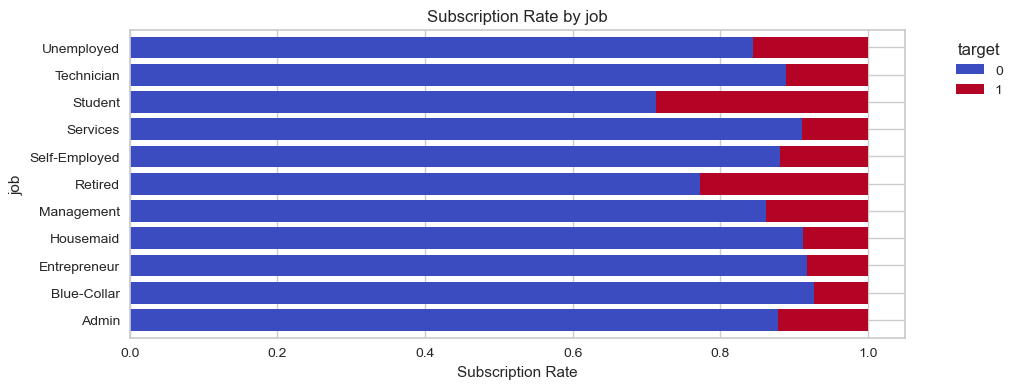

In [11]:
plot_stacked_bar_horizontal(df, 'job', palette='coolwarm')

**Interpretation:**
Students and Retired individuals have the highest subscription rates at 28.68% and 22.79%, respectively. This suggests that these groups are more likely to subscribe to the bank product compared to others.
Blue-Collar workers have the lowest subscription rate at 7.27%, indicating they are less likely to subscribe.
Management and Unemployed individuals also show relatively higher subscription rates at 13.76% and 15.50%, respectively.

## Marital Status

In [13]:
value_cnt_norm_cal(df,'marital')

,Count,Frequency (%)
marital,,
Married,27214,60.193316
Single,12790,28.289576
Divorced,5207,11.517109


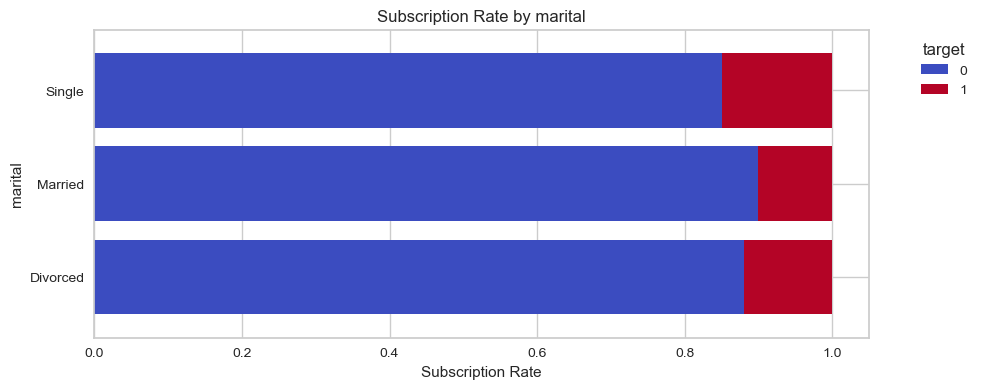

In [12]:
plot_stacked_bar_horizontal(df, 'marital', palette='coolwarm')

**Interpretation:**
Single individuals have the highest subscription rate at 14.95%, suggesting they are more likely to subscribe to the bank product compared to those who are married or divorced.
Married individuals have the lowest subscription rate at 10.12%, indicating they are less likely to subscribe.
Divorced individuals fall in between, with a subscription rate of 11.95%.

## Education Level

In [15]:
value_cnt_norm_cal(df,'education')

,Count,Frequency (%)
education,,
Secondary,23202,53.517553
Tertiary,13301,30.679983
Primary,6851,15.802463


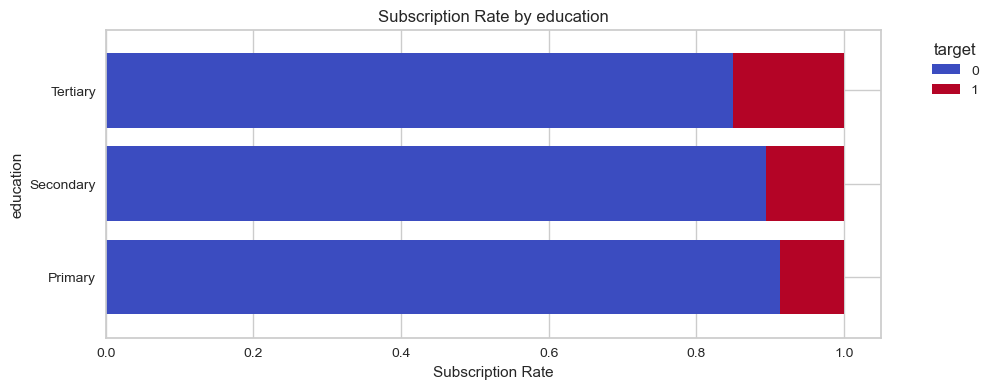

In [13]:
plot_stacked_bar_horizontal(df, 'education', palette='coolwarm')

**Interpretation:**
Tertiary educated individuals have the highest subscription rate at 15.01%, indicating they are more likely to subscribe to the bank product compared to those with primary or secondary education.
Primary educated individuals have the lowest subscription rate at 8.63%, suggesting they are less likely to subscribe.
Secondary educated individuals fall in between, with a subscription rate of 10.56%.

## Has credit in default?

In [17]:
value_cnt_norm_cal(df,'default')

,Count,Frequency (%)
default,,
No,44396,98.197341
Yes,815,1.802659


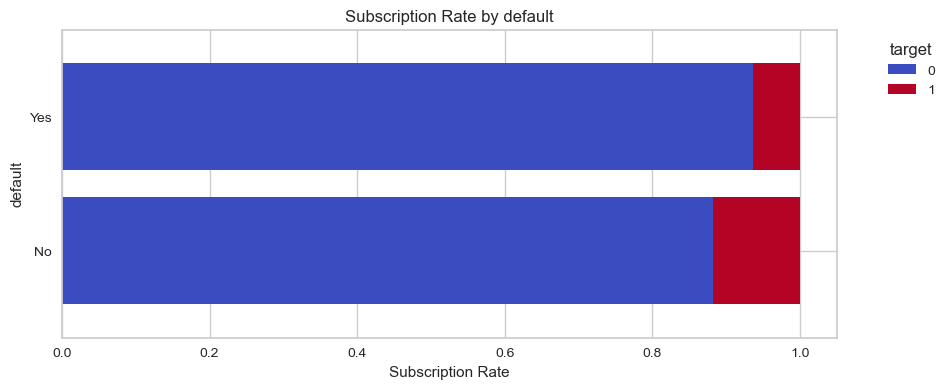

In [14]:
plot_stacked_bar_horizontal(df, 'default', palette='coolwarm')

**Interpretation:**
Individuals with no credit default have a higher subscription rate at 11.80%, indicating they are more likely to subscribe to the bank product compared to those with a credit default.
Individuals with a credit default have a lower subscription rate at 6.38%, suggesting they are less likely to subscribe.

## Has housing loan?

In [20]:
value_cnt_norm_cal(df,'housing')

,Count,Frequency (%)
housing,,
Yes,25130,55.583818
No,20081,44.416182


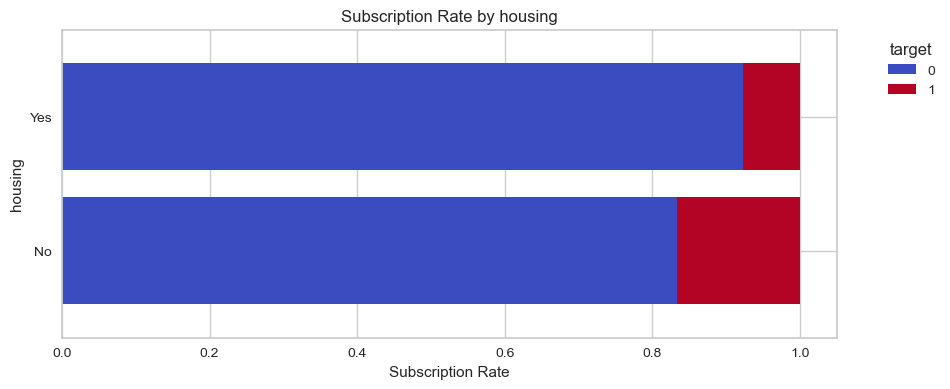

In [15]:
plot_stacked_bar_horizontal(df, 'housing', palette='coolwarm')

**Interpretation:**
Individuals with no housing loan have a higher subscription rate at 16.70%, indicating they are more likely to subscribe to the bank product compared to those with a housing loan.
Individuals with a housing loan have a lower subscription rate at 7.70%, suggesting they are less likely to subscribe.

## Has personal loan?

In [39]:
value_cnt_norm_cal(df,'loan')

,Count,Frequency (%)
loan,,
No,37967,83.977351
Yes,7244,16.022649


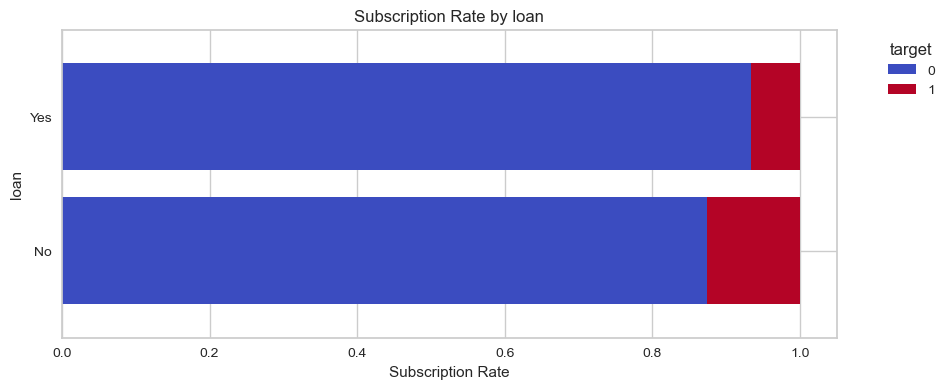

In [16]:
plot_stacked_bar_horizontal(df, 'loan', palette='coolwarm')

**Interpretation:**
Individuals with no personal loan have a higher subscription rate at 12.66%, indicating they are more likely to subscribe to the bank product compared to those with a personal loan.
Individuals with a personal loan have a lower subscription rate at 6.68%, suggesting they are less likely to subscribe.

## Contact communication type

In [25]:
value_cnt_norm_cal(df,'contact')

,Count,Frequency (%)
contact,,
Cellular,29285,90.972632
Telephone,2906,9.027368


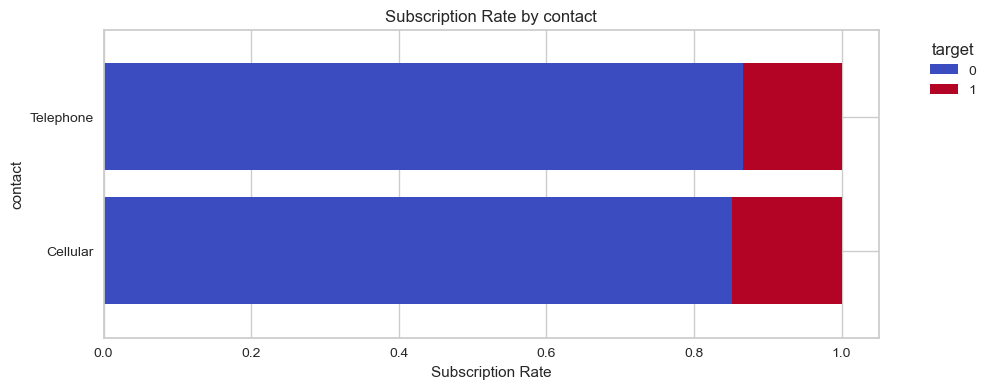

In [17]:
plot_stacked_bar_horizontal(df, 'contact', palette='coolwarm')

**Interpretation:**
Individuals contacted via cellular have a slightly higher subscription rate at 14.92% compared to those contacted via telephone, who have a subscription rate of 13.42%.
This suggests that contacting potential customers via cellular might be slightly more effective in terms of subscription rates.

## last contact month of year

In [27]:
value_cnt_norm_cal(df,'month')

,Count,Frequency (%)
month,,
May,13766,30.448342
Jul,6895,15.250713
Aug,6247,13.817434
Jun,5341,11.813497
Nov,3970,8.781049
Apr,2932,6.485147
Feb,2649,5.859194
Jan,1403,3.103227
Oct,738,1.632346


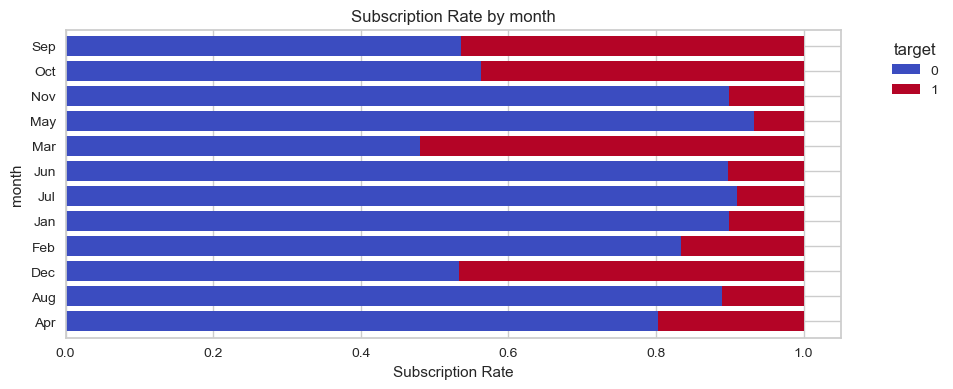

In [18]:
plot_stacked_bar_horizontal(df, 'month', palette='coolwarm')

**Interpretation:**
March and December have the highest subscription rates at 51.99% and 46.73%, respectively, indicating that individuals contacted in these months are more likely to subscribe to the bank product.
May has the lowest subscription rate at 6.72%, suggesting that individuals contacted in this month are less likely to subscribe.
October and September also show relatively high subscription rates at 43.77% and 46.46%, respectively.

## Outcome of the previous marketing campaign

In [43]:
value_cnt_norm_cal(df,'poutcome')

,Count,Frequency (%)
poutcome,,
Failure,4901,59.391663
Other,1840,22.297625
Success,1511,18.310713


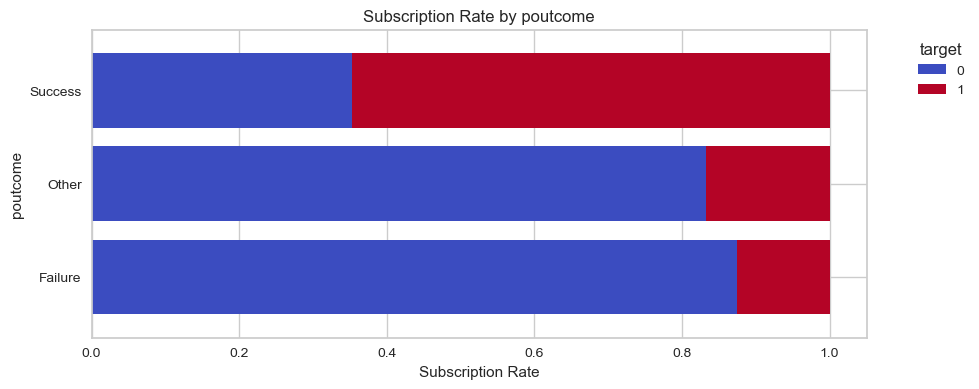

In [19]:
plot_stacked_bar_horizontal(df, 'poutcome', palette='coolwarm')

**Interpretation:**
Clients with a successful outcome in the previous campaign have the highest subscription rate at 64.73%, indicating they are much more likely to subscribe to the bank product compared to other groups.
Clients with a failure outcome have a lower subscription rate at 12.61%.
Clients categorized as other have a subscription rate of 16.68%, which is higher than those with a failure outcome but significantly lower than those with a success outcome.

## has the client subscribed a term deposit? (Target variable)

In [25]:
value_cnt_norm_cal(df,'y')

,Count,Frequency (%)
y,,
0,39922,88.30152
1,5289,11.69848


**Interpretation:**
The majority of clients, 88.30%, did not subscribe to the term deposit.
A smaller proportion, 11.70%, did subscribe.

## Age

In [63]:
df['age'].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

In [64]:
df['age'].skew()

0.6848179257252598

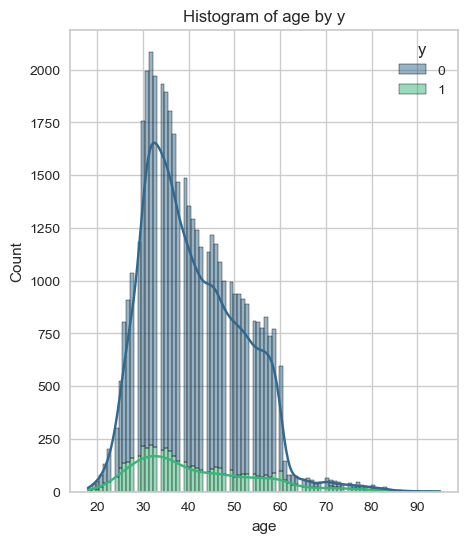

In [65]:
plot_histogram(df, 'age')

**Interpretation:**
The mean age of 40.94 years indicates that, on average, clients are around 41 years old.
The standard deviation of 10.62 years suggests there is a moderate range of ages, with some variability among clients.
The minimum age of 18 years indicates that the youngest clients are 18 years old.
The 25th percentile value of 33 years shows that 25% of clients are younger than 33 years.
The median age of 39 years indicates that half of the clients are younger than 39 years and half are older.
The 75th percentile value of 48 years shows that 75% of clients are younger than 48 years.
The maximum age of 95 years indicates that the oldest clients are 95 years old.

## Average yearly balance, in euros

In [66]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [68]:
df['balance'].skew()

8.360308326166326

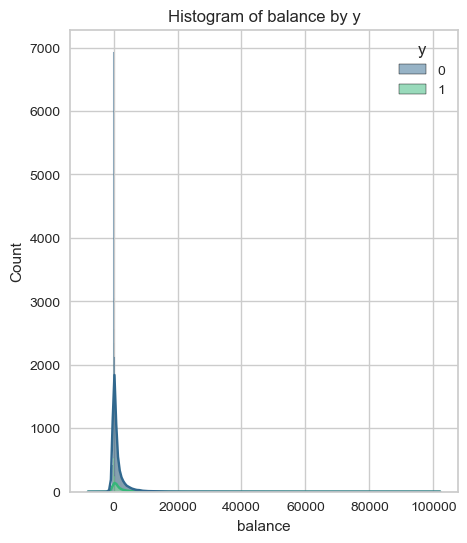

In [69]:
plot_histogram(df, 'balance')

**Interpretation:**
The mean balance of €1,362.27 indicates that, on average, clients have a balance of around €1,362.27.
The standard deviation of €3,044.77 suggests there is a wide range of balances, with significant variability among clients.
The minimum balance of -€8,019.00 indicates that some clients have negative balances, possibly due to overdrafts.
The 25th percentile value of €72.00 shows that 25% of clients have balances below €72.00, indicating a lower quartile with relatively small balances.
The median balance of €448.00 indicates that half of the clients have balances below €448.00 and half above.
The 75th percentile value of €1,428.00 shows that 75% of clients have balances below €1,428.00, indicating a higher quartile with relatively larger balances.
The maximum balance of €102,127.00 indicates that some clients have very high balances.

## Last contact duration, in seconds

In [73]:
df['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [74]:
df['duration'].skew()

3.144318099423456

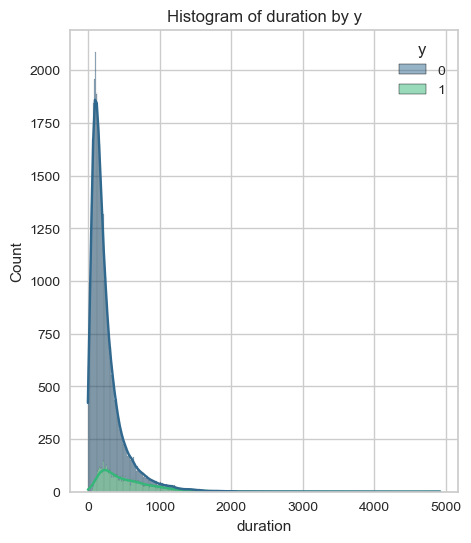

In [75]:
plot_histogram(df, 'duration')

## Duration Bins

In [98]:
value_cnt_norm_cal(df,'duration_bins')

,Count,Frequency (%)
duration_bins,,
"(100.0, 200.0]",13989,30.943638
"(0.0, 100.0]",10880,24.066537
"(200.0, 300.0]",8065,17.839763
"(300.0, 400.0]",4416,9.768183
"(400.0, 500.0]",2487,5.501239
"(500.0, 600.0]",1581,3.497169
"(600.0, 700.0]",1125,2.488498
"(1000.0, inf]",1058,2.340294
"(700.0, 800.0]",736,1.628030


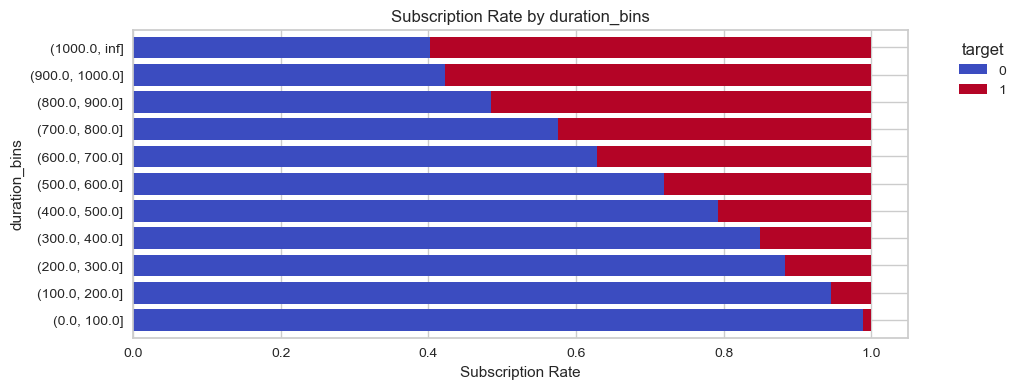

In [20]:
plot_stacked_bar_horizontal(df, 'duration_bins', palette='coolwarm')

**Interpretation:**
As the duration of the last contact increases, the subscription rate also increases significantly.
For contacts lasting 1000 seconds or more, the subscription rate is the highest at 59.74%.
For very short contacts (0.0 to 100.0 seconds), the subscription rate is the lowest at 1.08%.
Longer calls likely indicate that the customer is engaged and interested, providing more opportunities for the agent to address concerns and highlight benefits

## Scatter plots

Text(0.5, 0.98, 'Pairplot: Numerical Features ')

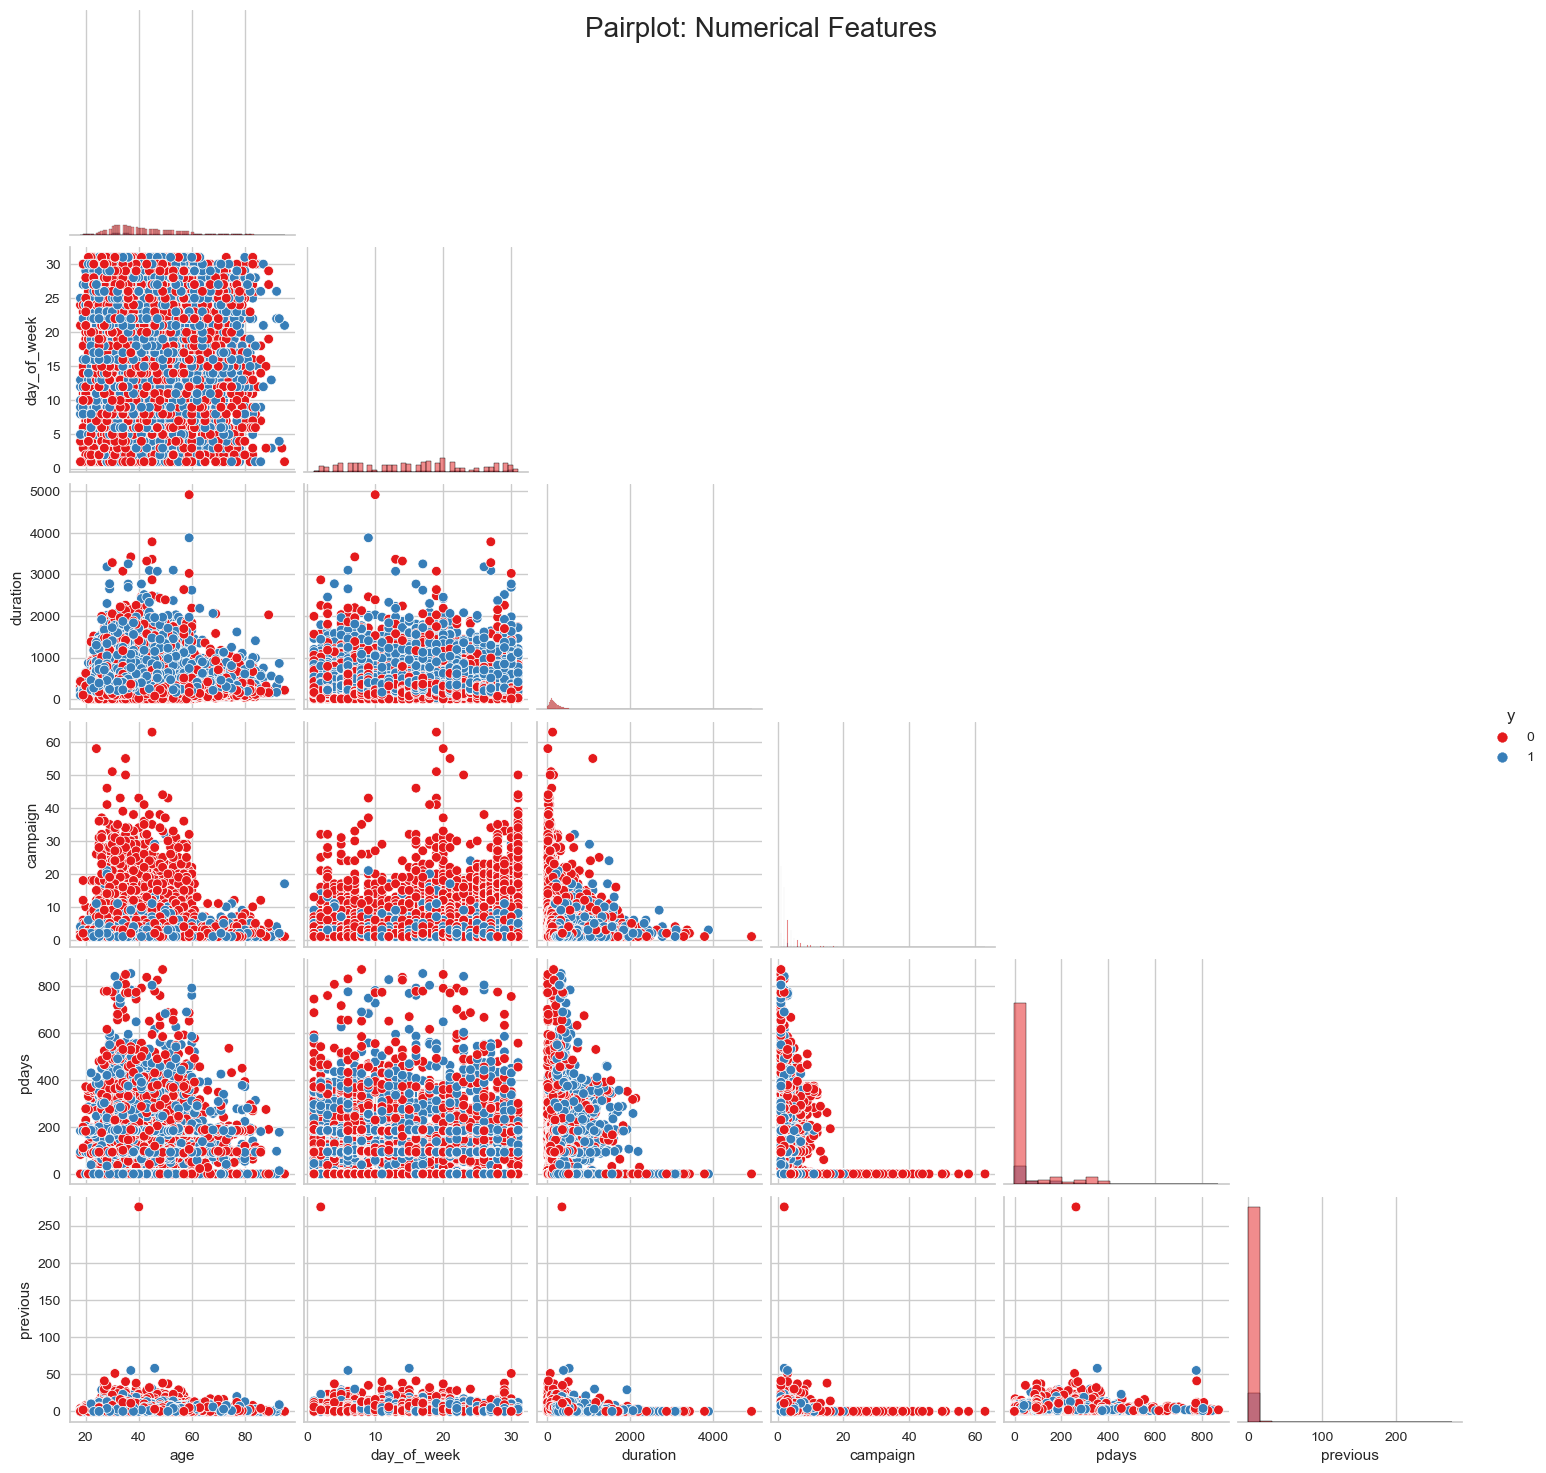

In [93]:
# Pairplots of Numerical Features
numerical= ['age', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'y']
data = df[numerical]
g = sns.pairplot(data, hue="y", corner=True, diag_kind='hist', palette='Set1');
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 20)

## Correlation Analysis

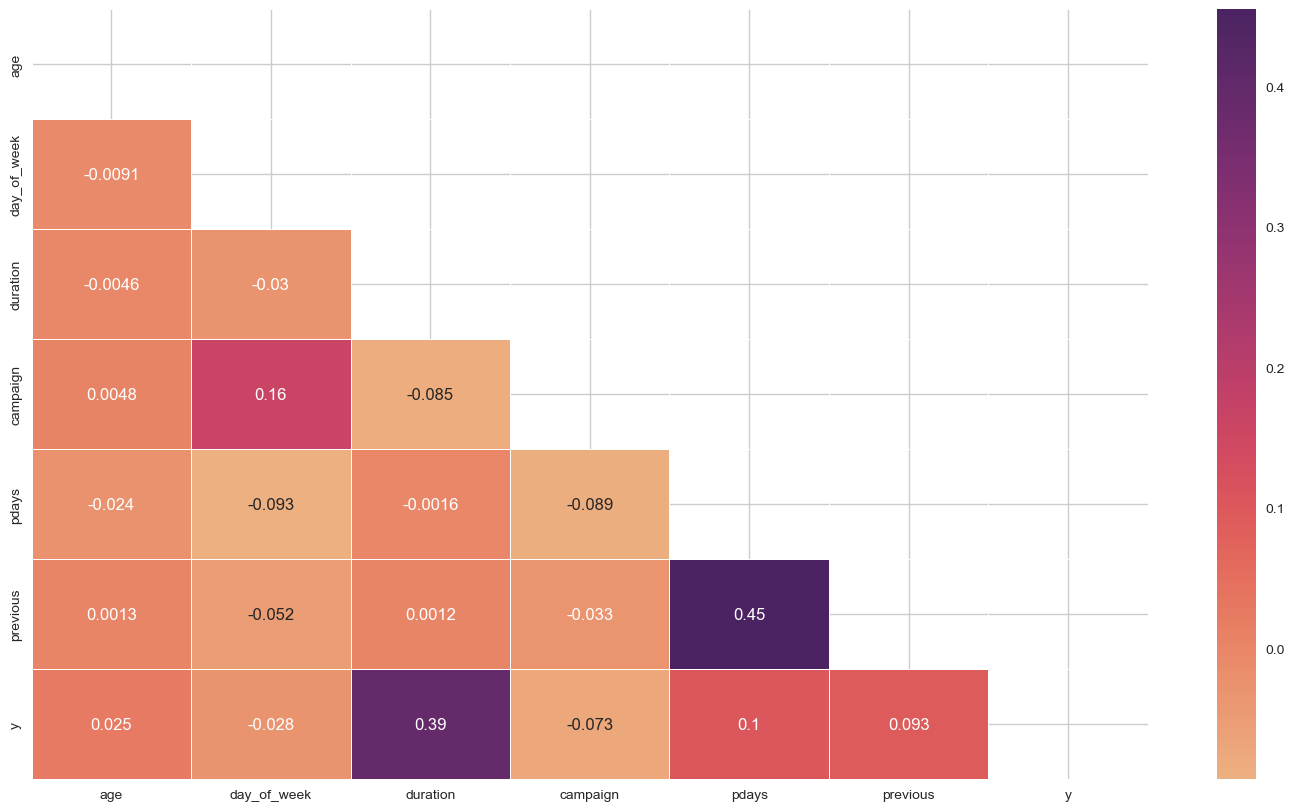

In [96]:
corr =df[['age', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'y']].corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

**Key Insights:**
Duration of the call has the strongest positive correlation with the target variable y (0.395), suggesting that longer calls are more effective in securing subscriptions.
Campaign has a slight negative correlation with y (-0.073), indicating that clients contacted more frequently in the current campaign are less likely to subscribe.
Pdays and previous show positive correlations with y, suggesting that clients with longer intervals since the last contact and more previous contacts are more likely to subscribe.

**Overall Summary:**
The dataset reveals that certain demographic factors (like job, marital status, and education), financial factors (like credit default, housing loan, and personal loan status), and behavioral factors (like contact communication type, last contact month, and duration of the last contact) significantly influence the likelihood of clients subscribing to a term deposit. Longer call durations and successful outcomes from previous campaigns are particularly strong predictors of subscription.

These insights can help the bank tailor its marketing strategies to target specific groups more effectively and optimize their campaign efforts.

## Split the data into training and test sets

In [8]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [9]:
train, test = data_split(df, 0.2)

In [10]:
train.shape, test.shape

((36168, 18), (9043, 18))

In [11]:
train.to_csv('dataset/train.csv',index=False)
test.to_csv('dataset/test.csv',index=False)

In [12]:
# creating a copy of the dataset so that the original stays untouched
train_copy = train.copy()
test_copy = test.copy()

# Prepare data

## Data Cleaning

### Outliers handling

In [13]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers=None):
        self.feat_with_outliers = feat_with_outliers or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_features = set(self.feat_with_outliers) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        # Calculate 25% and 75% quantiles
        Q1 = X[self.feat_with_outliers].quantile(0.25)
        Q3 = X[self.feat_with_outliers].quantile(0.75)
        IQR = Q3 - Q1

        # Keep data within 3 IQR
        X = X[~((X[self.feat_with_outliers] < (Q1 - 3 * IQR)) | (X[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
        return X

### Fix Skewness

In [14]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self, col_with_skewness=None):
        self.col_with_skewness = col_with_skewness or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_features = set(self.col_with_skewness) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        X[self.col_with_skewness] = np.cbrt(X[self.col_with_skewness])
        return X

### Binning

In [15]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['default','housing','loan']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to No and 1 to Yes for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Yes',0:'No'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Missing value imputer

In [16]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_imputed_ft=None, median_imputed_ft=None):
        self.mode_imputed_ft = mode_imputed_ft or []
        self.median_imputed_ft = median_imputed_ft or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_features = set(self.mode_imputed_ft + self.median_imputed_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        # Drop missing values in the target feature
        X.dropna(inplace=True, axis=0, subset=['y'])

        # Impute missing values with mode
        for ft in self.mode_imputed_ft:
            the_mode = X[ft].mode()[0]
            X[ft] = X[ft].fillna(the_mode)

        # Impute missing values with median
        for ft in self.median_imputed_ft:
            the_median = X[ft].median()
            X[ft] = X[ft].fillna(the_median)

        return X

### One hot encoding

In [17]:
class OneHotWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc_ft=None):
        self.one_hot_enc_ft = one_hot_enc_ft or []
        self.one_hot_enc = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        self.one_hot_enc.fit(X[self.one_hot_enc_ft])
        self.feat_names_one_hot_enc = self.one_hot_enc.get_feature_names_out(self.one_hot_enc_ft)
        return self

    def transform(self, X):
        missing_features = set(self.one_hot_enc_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        one_hot_enc_df = pd.DataFrame(self.one_hot_enc.transform(X[self.one_hot_enc_ft]).toarray(), columns=self.feat_names_one_hot_enc, index=X.index)
        rest_of_features = [ft for ft in X.columns if ft not in self.one_hot_enc_ft]
        df_concat = pd.concat([one_hot_enc_df, X[rest_of_features]], axis=1)
        return df_concat

### Drop features

In [18]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_drop=None):
        self.feature_to_drop = feature_to_drop or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_features = set(self.feature_to_drop) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")
        return X.drop(columns=self.feature_to_drop)

### Min Max scalling

In [19]:
class MinMaxWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, min_max_scaler_ft=None):
        self.min_max_scaler_ft = min_max_scaler_ft or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_features = set(self.min_max_scaler_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        min_max_enc = MinMaxScaler()
        X[self.min_max_scaler_ft] = min_max_enc.fit_transform(X[self.min_max_scaler_ft])
        return X

### Oversampling

In [20]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'y' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'y'],df['y'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("y is not in the dataframe")
            return df

## Data Preprocessing

In [21]:
# Create the pipeline
pipeline = Pipeline([
    ('missing value imputer', MissingValueImputer(mode_imputed_ft=['job', 'education', 'contact', 'poutcome'])),
    ('outlier remover', OutlierRemover(feat_with_outliers=['age', 'balance'])),
    ('skewness transformer', SkewnessHandler(col_with_skewness=['age', 'balance', 'duration'])),
    ('binning_num_to_yn', BinningNumToYN()),
    ('drop features', DropFeatures(feature_to_drop=['month', 'day_of_week', 'duration_bins', 'campaign', 'pdays', 'previous'])),
    ('one hot encoding', OneHotWithFeatNames(one_hot_enc_ft=['job', 'marital', 'education', 'contact', 'poutcome', 'default','housing','loan'])),
    ('min max scaler', MinMaxWithFeatNames(min_max_scaler_ft=['age', 'balance', 'duration'])),
    ('oversample', Oversample())
])

In [22]:
# Apply the pipeline to the DataFrame
train_pipe_prep = pipeline.fit_transform(train_copy)

In [23]:
train_pipe_prep.shape

(60588, 29)

In [24]:
# split the train data into X and y (target)
X_train, y_train = train_pipe_prep.loc[:, train_pipe_prep.columns != 'y'], train_pipe_prep['y'].astype('int64')

In [25]:
X_train.head()

,job_Admin,job_Blue-Collar,job_Entrepreneur,job_Housemaid,job_Management,job_Retired,job_Self-Employed,job_Services,job_Student,job_Technician,...,contact_Telephone,poutcome_Failure,poutcome_Other,poutcome_Success,default_nan,housing_nan,loan_nan,age,balance,duration
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.433253,0.749211,0.264726
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.543776,0.803041,0.410774
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.447814,0.938875,0.322354
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.372520,0.308598,0.458877
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.630982,0.924110,0.408213


In [26]:
# y_train

# Short-list models

## Models training

In [27]:
model_list = [
    LogisticRegression(random_state=42,max_iter=1000),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GaussianNB(),
    GradientBoostingClassifier(random_state=42),
    LinearDiscriminantAnalysis(),
    BaggingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
]

In [31]:
def evaluate_models(model_list, X_train, y_train, scoring):
    # Dictionary to store trained models
    trained_models = {}

    # Create the 'images' directory if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')

    for model in model_list:
        # Fit the model
        model.fit(X_train, y_train)

        # Print model name
        print(str(model))
        
        # Perform cross-validation and print scores
        cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_estimator=True)
        for score in scoring:
            print(f'{score.capitalize()} scores: {cv_results["test_" + score]}')
            print(f'Mean {score.capitalize()}: {cv_results["test_" + score].mean():.10}')
        
        # Store the trained model (using the last estimator from cross-validation)
        trained_models[str(model)] = cv_results['estimator'][-1]
        
        # Generate cross-validated predictions and classification report on the training set
        y_train_pred = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1)[:, 1]
        print(f'Classification Report for {str(model)} on Training Set:\n')
        print(classification_report(y_train, y_train_pred > 0.5))
        
        # Plot confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred > 0.5, cmap='Blues', values_format='d')
        plt.title(f'Confusion Matrix for {str(model)} on Training Set')
        plt.savefig(f'images/{str(model)}_confusion_matrix.png', bbox_inches='tight')
        plt.show()
        
        # Get feature importances or coefficients
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]
        else:
            importances = np.zeros(X_train.shape[1])
        
        # Get feature names
        feature_names = X_train.columns
        
        # Get indices of top 10 and bottom 10 features
        indices = np.argsort(importances)
        top_10_indices = indices[-10:]
        bottom_10_indices = indices[:10]
        
        # Plot top 10 features
        plt.figure(figsize=(10, 4))
        plt.barh(range(len(top_10_indices)), importances[top_10_indices], align='center', color='skyblue')
        plt.yticks(range(len(top_10_indices)), [feature_names[i] for i in top_10_indices])
        plt.xlabel('Importance')
        plt.title(f'Top 10 Features for {str(model)}')
        plt.savefig(f'images/{str(model)}_top_10_features.png', bbox_inches='tight')
        plt.show()
        
        # Plot bottom 10 features
        plt.figure(figsize=(10, 4))
        plt.barh(range(len(bottom_10_indices)), importances[bottom_10_indices], align='center', color='salmon')
        plt.yticks(range(len(bottom_10_indices)), [feature_names[i] for i in bottom_10_indices])
        plt.xlabel('Importance')
        plt.title(f'Bottom 10 Features for {str(model)}')
        plt.savefig(f'images/{str(model)}_bottom_10_features.png', bbox_inches='tight')
        plt.show()
        
        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_train, y_train_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(f'images/{str(model)}_roc_curve.png', bbox_inches='tight')
        plt.show()
        
        print('\n')

    return trained_models

LogisticRegression(max_iter=1000, random_state=42)
Precision scores: [0.809817   0.80929839 0.80192755 0.80715739 0.80757576]
Mean Precision: 0.8071552194
Recall scores: [0.78148209 0.79006437 0.79650107 0.7855728  0.7917148 ]
Mean Recall: 0.7890670267
F1 scores: [0.79539728 0.79956573 0.7992051  0.79621884 0.79956663]
Mean F1: 0.7979907149
Accuracy scores: [0.79897673 0.80194752 0.79988447 0.79896014 0.80151853]
Mean Accuracy: 0.8002574761
Roc_auc scores: [0.87992367 0.88453035 0.88203818 0.8831104  0.88474395]
Mean Roc_auc: 0.8828693096
Classification Report for LogisticRegression(max_iter=1000, random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     30294
           1       0.81      0.79      0.80     30294

    accuracy                           0.80     60588
   macro avg       0.80      0.80      0.80     60588
weighted avg       0.80      0.80      0.80     60588



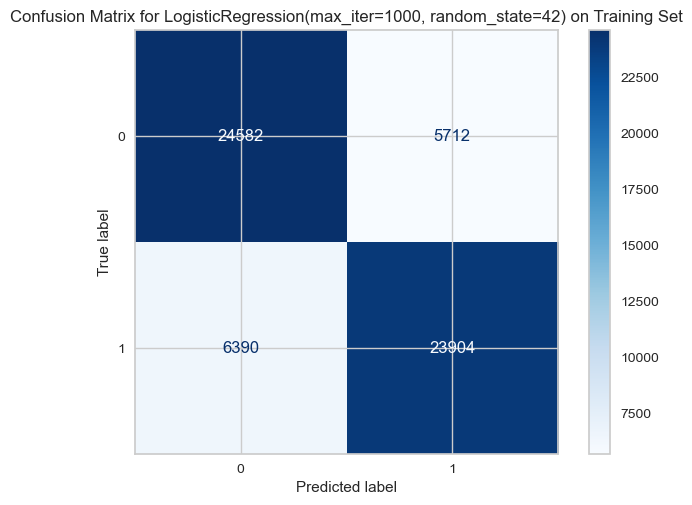

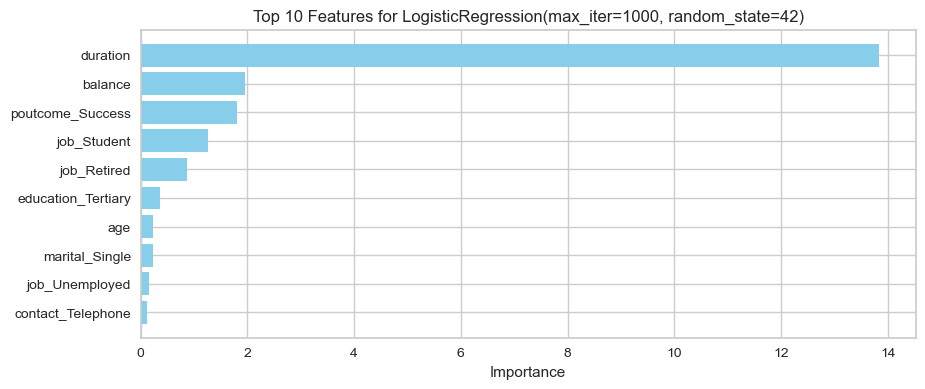

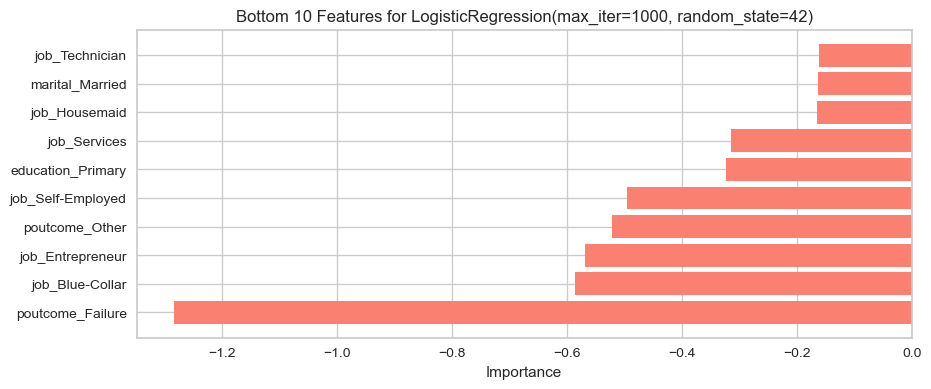

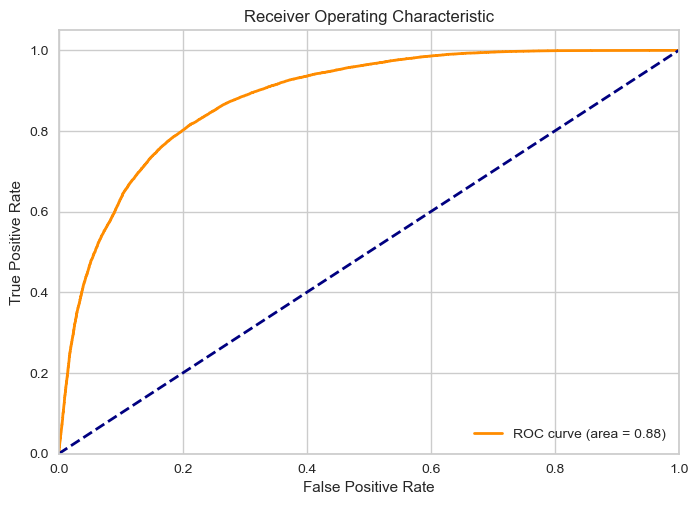



DecisionTreeClassifier(random_state=42)
Precision scores: [0.85068618 0.84187082 0.84604362 0.84533291 0.8359412 ]
Mean Precision: 0.8439749491
Recall scores: [0.76728833 0.87341145 0.87704242 0.87603169 0.87291632]
Mean Recall: 0.8533380436
F1 scores: [0.8068379  0.85735115 0.86126418 0.86040856 0.85402874]
Mean F1: 0.8479781084
Accuracy scores: [0.81630632 0.85467899 0.85872256 0.85788562 0.85078815]
Mean Accuracy: 0.8476763273
Roc_auc scores: [0.81630632 0.85467899 0.85872256 0.85788711 0.85078632]
Mean Roc_auc: 0.8476762616
Classification Report for DecisionTreeClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     30294
           1       0.84      0.85      0.85     30294

    accuracy                           0.85     60588
   macro avg       0.85      0.85      0.85     60588
weighted avg       0.85      0.85      0.85     60588



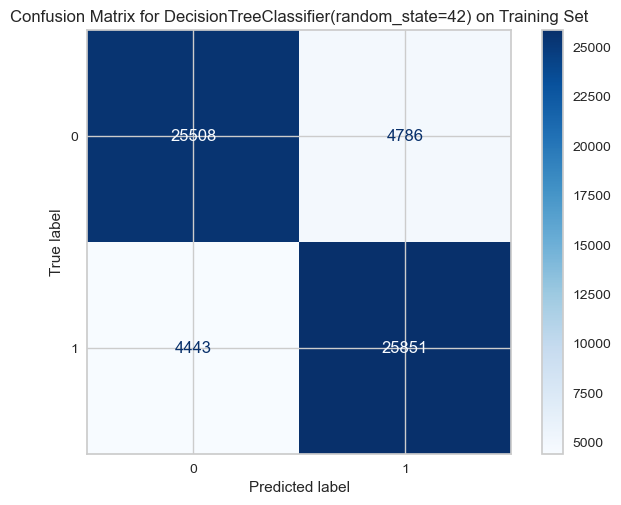

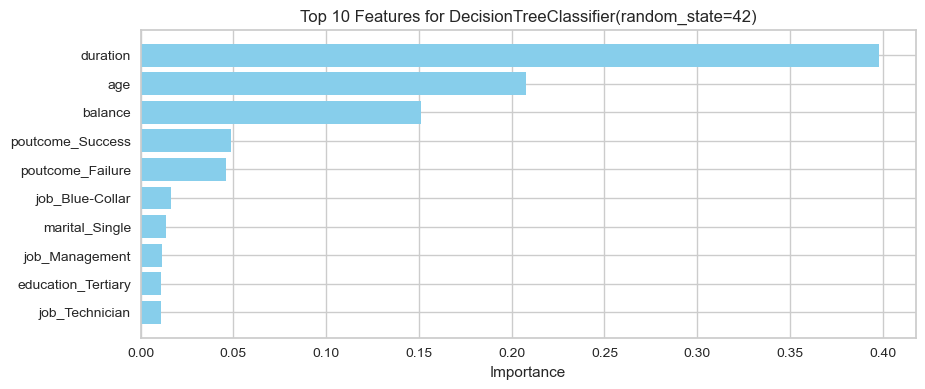

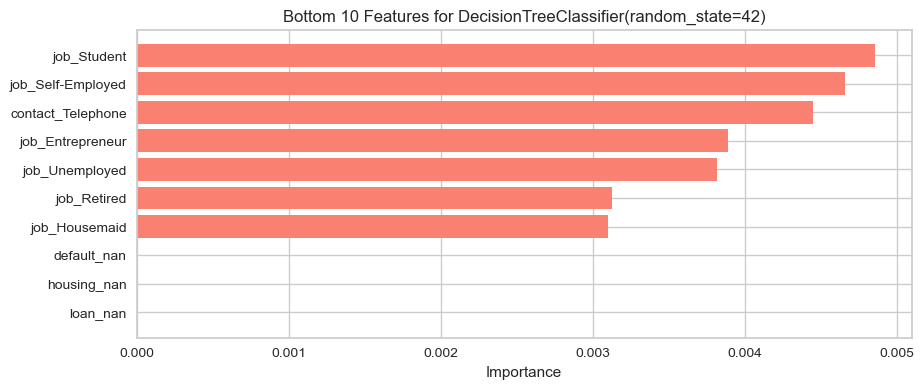

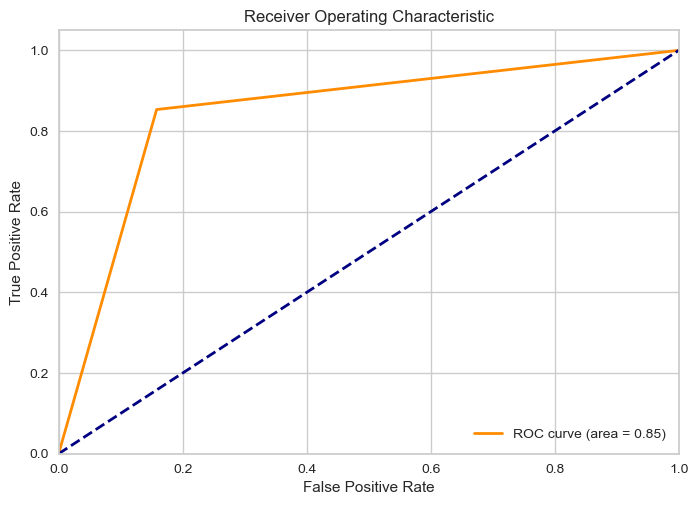



RandomForestClassifier(random_state=42)
Precision scores: [0.87914769 0.88360528 0.87688752 0.87935035 0.8789612 ]
Mean Precision: 0.8795904082
Recall scores: [0.8920614  0.93843869 0.9392639  0.93842852 0.93843869]
Mean Recall: 0.9293262396
F1 scores: [0.88555747 0.91019689 0.90700454 0.90792941 0.90772669]
Mean F1: 0.9036830012
Accuracy scores: [0.88471695 0.90741046 0.90369698 0.90484443 0.90459685]
Mean Accuracy: 0.9010531349
Roc_auc scores: [0.95335917 0.96762796 0.96764429 0.96844086 0.96827691]
Mean Roc_auc: 0.9650698378
Classification Report for RandomForestClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     30294
           1       0.88      0.93      0.90     30294

    accuracy                           0.90     60588
   macro avg       0.90      0.90      0.90     60588
weighted avg       0.90      0.90      0.90     60588



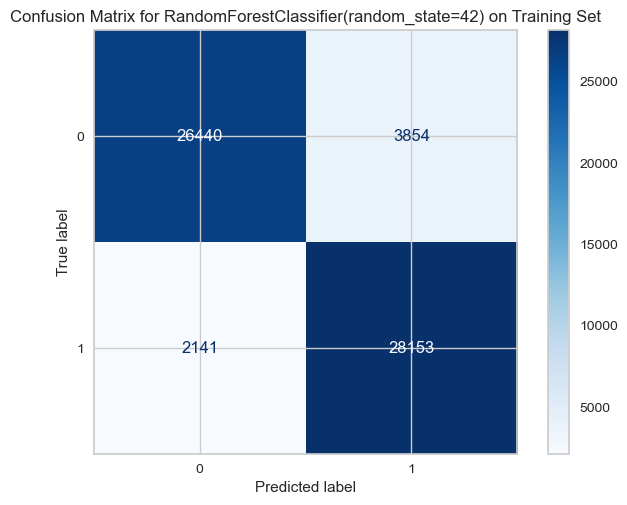

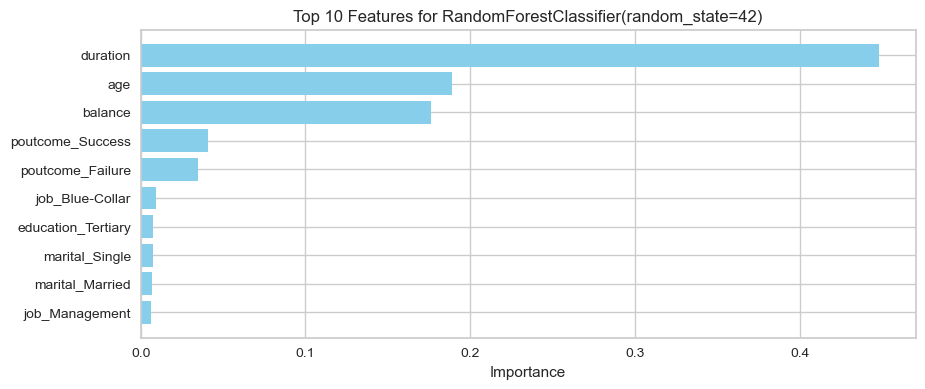

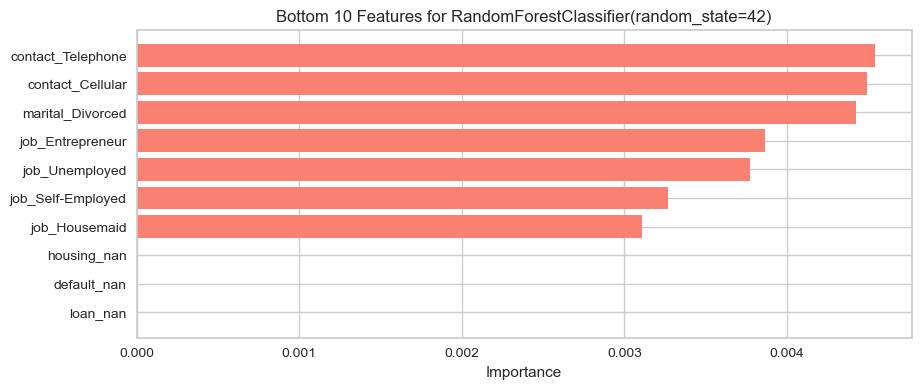

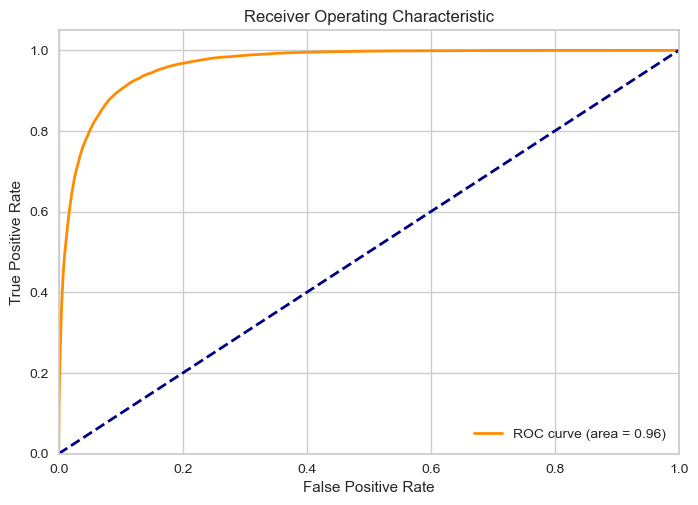



GaussianNB()
Precision scores: [0.78012855 0.76976682 0.76957912 0.76612466 0.77237354]
Mean Precision: 0.7715945369
Recall scores: [0.4807724  0.47400561 0.47681136 0.46665566 0.45865654]
Mean Recall: 0.4713803154
F1 scores: [0.59491474 0.58672114 0.58881076 0.58001641 0.57554106]
Mean F1: 0.5852008224
Accuracy scores: [0.67263575 0.66611652 0.66702426 0.66212759 0.66171495]
Mean Accuracy: 0.6659238132
Roc_auc scores: [0.79953128 0.79535323 0.79132389 0.79289934 0.79906187]
Mean Roc_auc: 0.7956339228
Classification Report for GaussianNB() on Training Set:

              precision    recall  f1-score   support

           0       0.62      0.86      0.72     30294
           1       0.77      0.47      0.59     30294

    accuracy                           0.67     60588
   macro avg       0.70      0.67      0.65     60588
weighted avg       0.70      0.67      0.65     60588



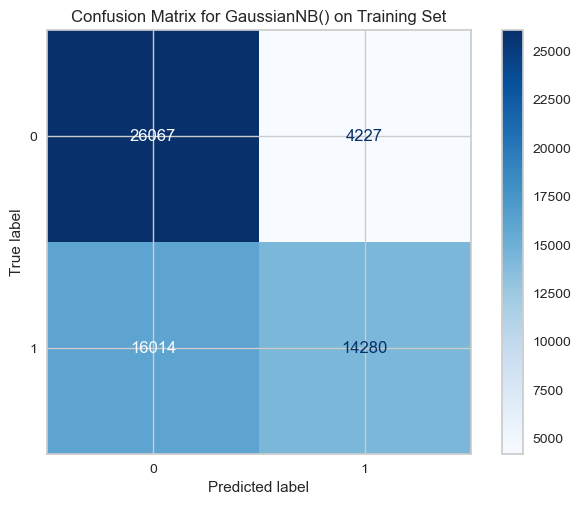

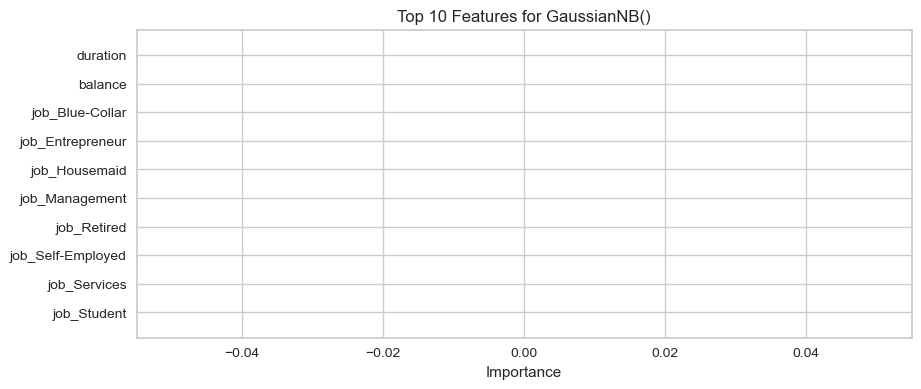

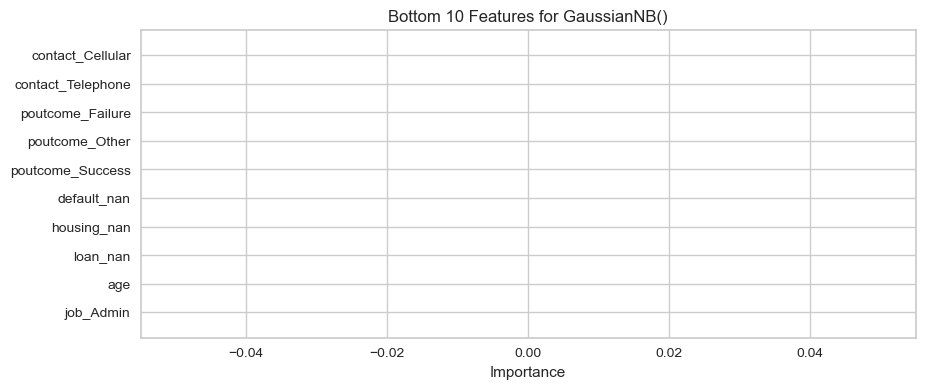

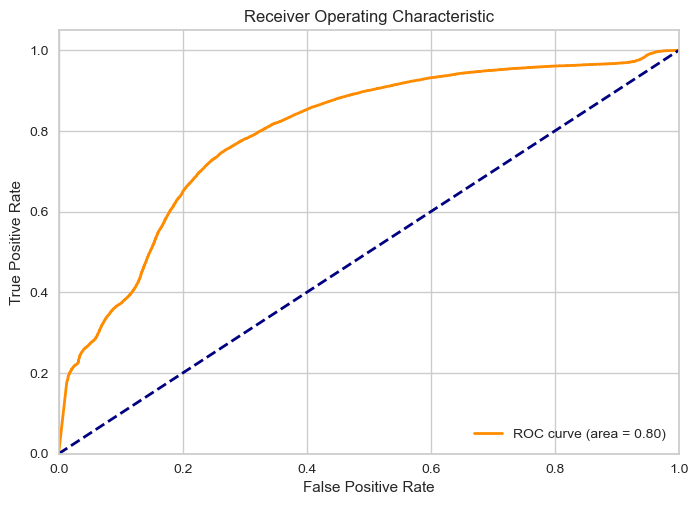



GradientBoostingClassifier(random_state=42)
Precision scores: [0.83699983 0.82958199 0.82251359 0.82904471 0.82553465]
Mean Precision: 0.8287349545
Recall scores: [0.79749134 0.85162568 0.84898498 0.8509409  0.84733454]
Mean Recall: 0.8392754891
F1 scores: [0.81676809 0.84045932 0.83553967 0.83985011 0.83629256]
Mean F1: 0.8337819501
Accuracy scores: [0.82109259 0.83833966 0.83289322 0.83774862 0.83411736]
Mean Accuracy: 0.8328382879
Roc_auc scores: [0.89836246 0.91746583 0.9151636  0.91908561 0.91645903]
Mean Roc_auc: 0.913307306
Classification Report for GradientBoostingClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     30294
           1       0.83      0.84      0.83     30294

    accuracy                           0.83     60588
   macro avg       0.83      0.83      0.83     60588
weighted avg       0.83      0.83      0.83     60588



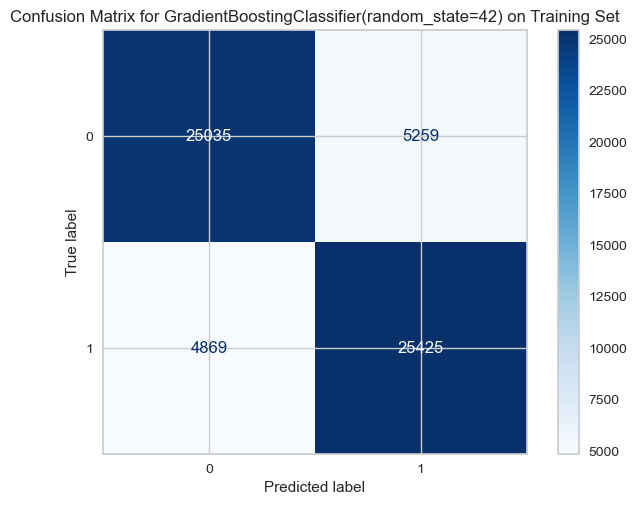

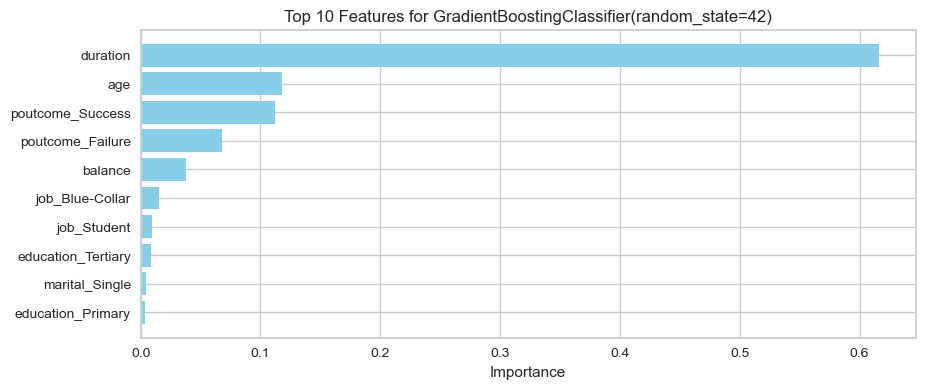

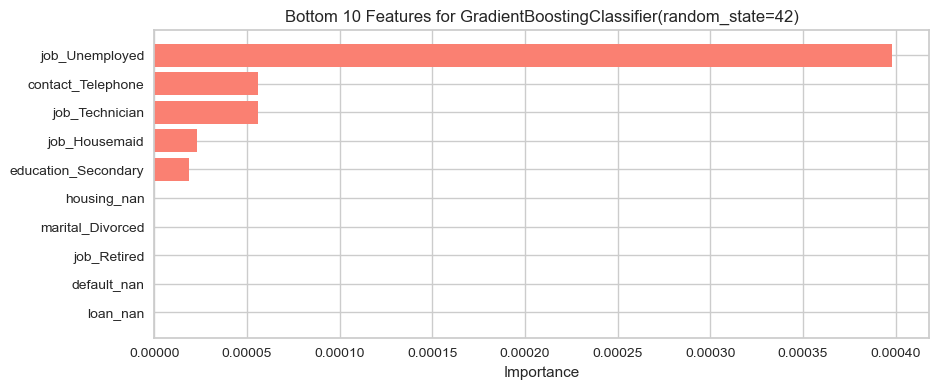

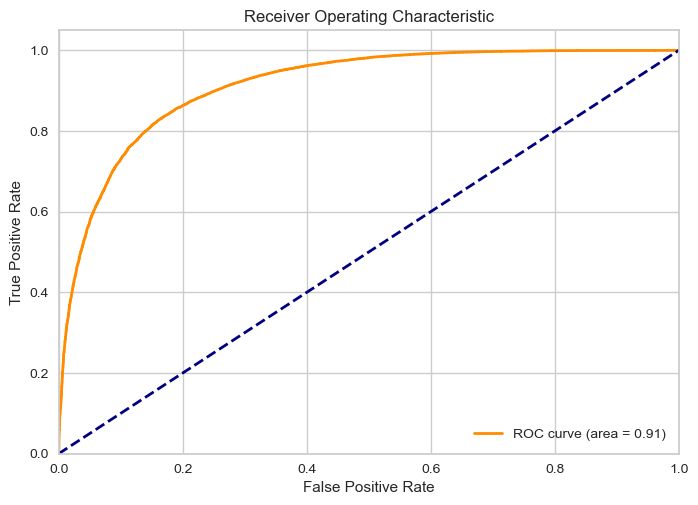



LinearDiscriminantAnalysis()
Precision scores: [0.81273731 0.81209318 0.80526938 0.81081545 0.81183896]
Mean Precision: 0.8105508581
Recall scores: [0.77719096 0.78247236 0.78692854 0.77963024 0.78544314]
Mean Recall: 0.7823330461
F1 scores: [0.79456678 0.79700765 0.79599332 0.79491711 0.79842295]
Mean F1: 0.7961815614
Accuracy scores: [0.79905925 0.80070969 0.79831655 0.79887761 0.80168359]
Mean Accuracy: 0.7997293375
Roc_auc scores: [0.87931209 0.88378409 0.88180041 0.88273746 0.88459975]
Mean Roc_auc: 0.8824467599
Classification Report for LinearDiscriminantAnalysis() on Training Set:

              precision    recall  f1-score   support

           0       0.79      0.82      0.80     30294
           1       0.81      0.78      0.80     30294

    accuracy                           0.80     60588
   macro avg       0.80      0.80      0.80     60588
weighted avg       0.80      0.80      0.80     60588



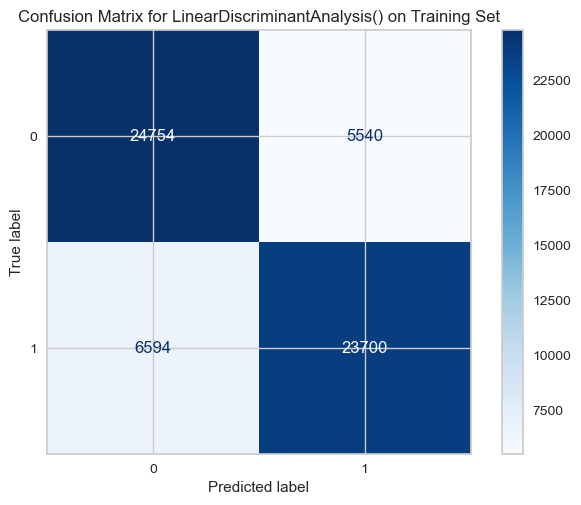

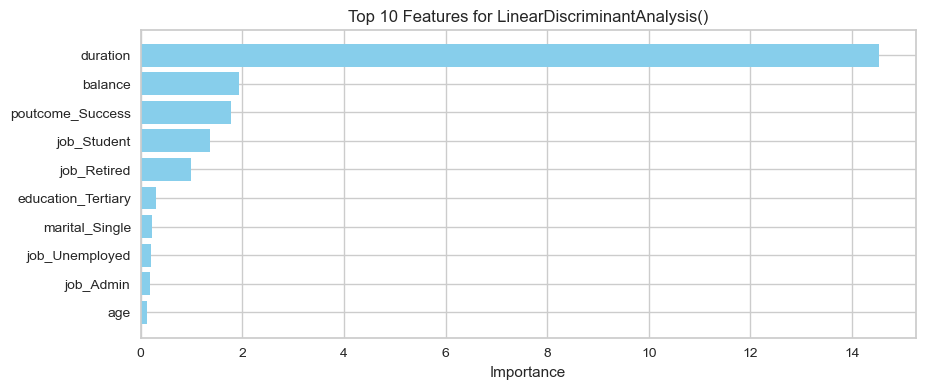

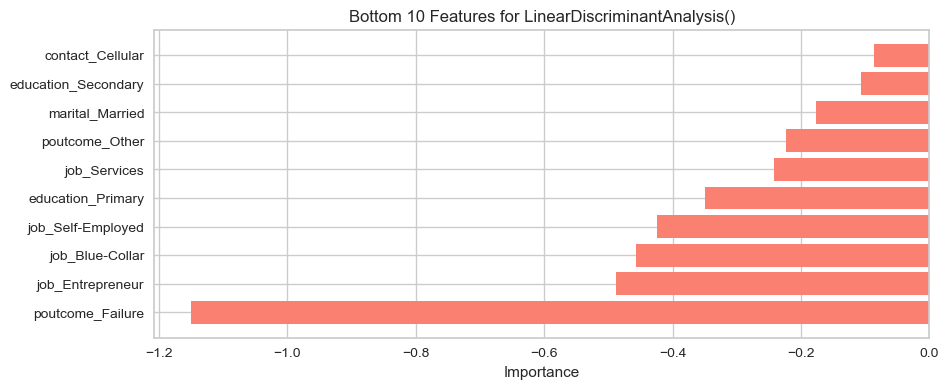

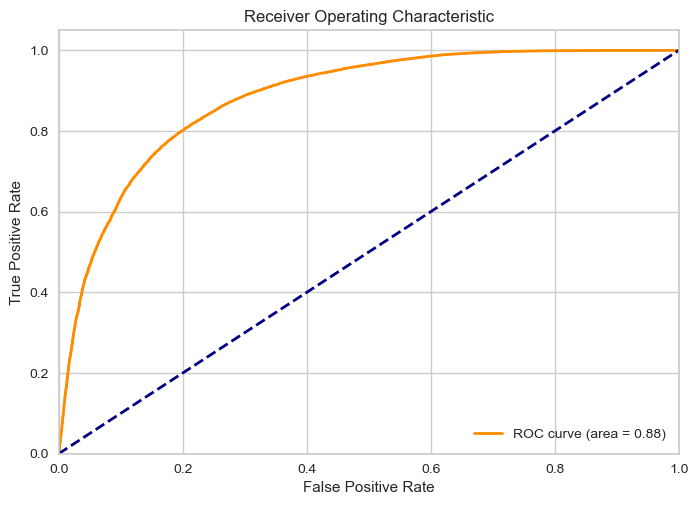



BaggingClassifier(random_state=42)
Precision scores: [0.89059923 0.8826671  0.87980154 0.88436796 0.88413749]
Mean Precision: 0.884314663
Recall scores: [0.80211256 0.90014854 0.90724542 0.90772532 0.90427463]
Mean Recall: 0.8843012948
F1 scores: [0.84404307 0.89132211 0.89331275 0.89589443 0.89409269]
Mean F1: 0.8837330097
Accuracy scores: [0.85179072 0.89024592 0.89164879 0.89452835 0.89287778]
Mean Accuracy: 0.8842183101
Roc_auc scores: [0.92870207 0.9502861  0.9508429  0.95350747 0.95373542]
Mean Roc_auc: 0.9474147909
Classification Report for BaggingClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     30294
           1       0.88      0.88      0.88     30294

    accuracy                           0.88     60588
   macro avg       0.88      0.88      0.88     60588
weighted avg       0.88      0.88      0.88     60588



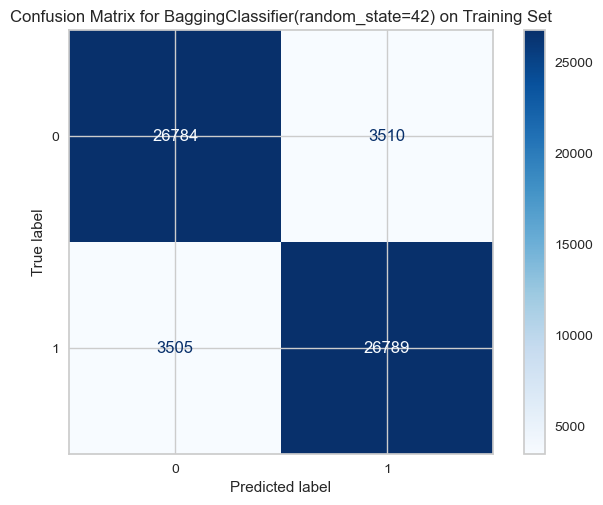

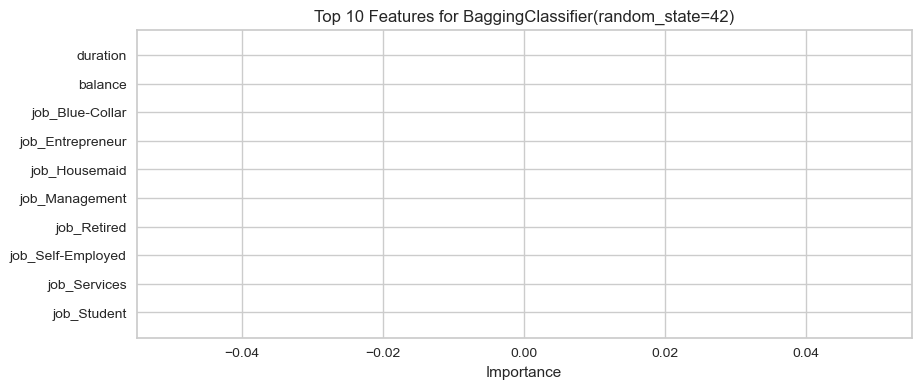

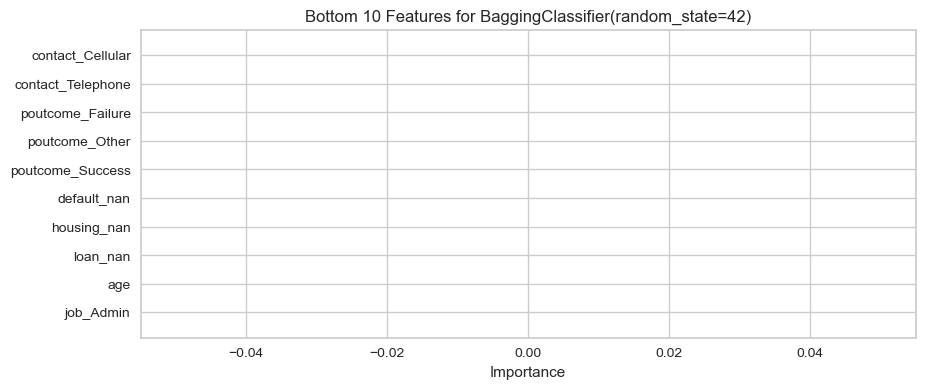

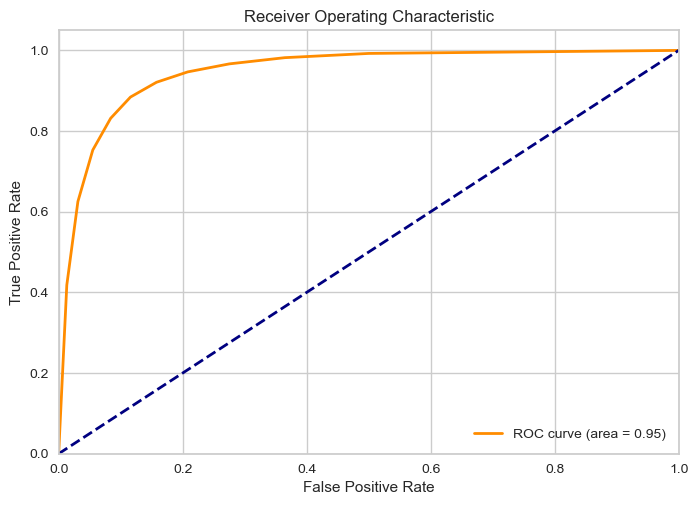



AdaBoostClassifier(random_state=42)
Precision scores: [0.81304126 0.81563061 0.8070233  0.81372711 0.81795635]
Mean Precision: 0.8134757261
Recall scores: [0.79022941 0.82505364 0.8116851  0.81413008 0.81647136]
Mean Recall: 0.8115139175
F1 scores: [0.80147305 0.82031506 0.80934749 0.81392854 0.81721318]
Mean F1: 0.8124554649
Accuracy scores: [0.80425813 0.81927711 0.80879683 0.81389783 0.81736403]
Mean Accuracy: 0.8127187863
Roc_auc scores: [0.88366872 0.89810219 0.89195883 0.89628922 0.8972838 ]
Mean Roc_auc: 0.8934605513
Classification Report for AdaBoostClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     30294
           1       0.81      0.81      0.81     30294

    accuracy                           0.81     60588
   macro avg       0.81      0.81      0.81     60588
weighted avg       0.81      0.81      0.81     60588



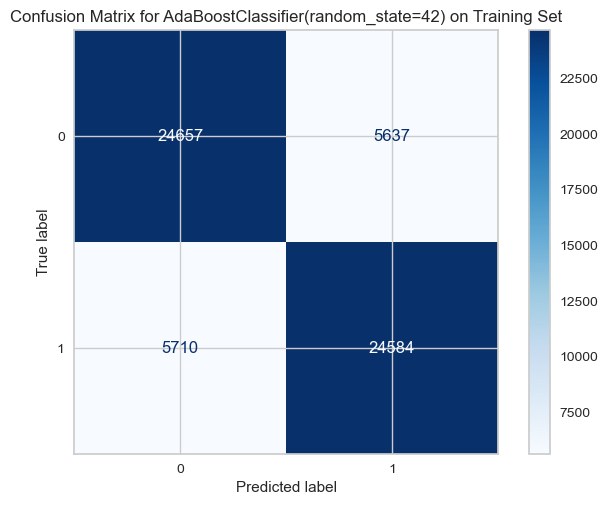

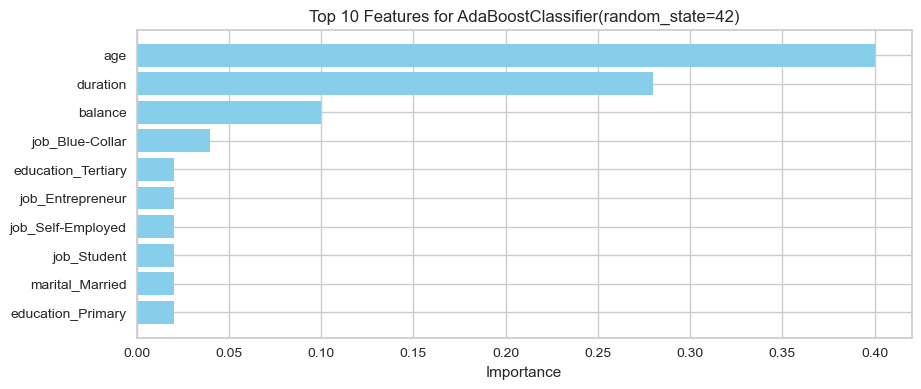

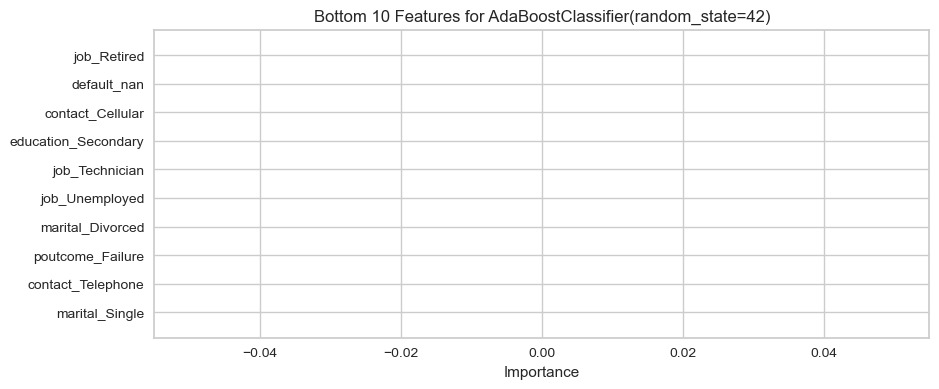

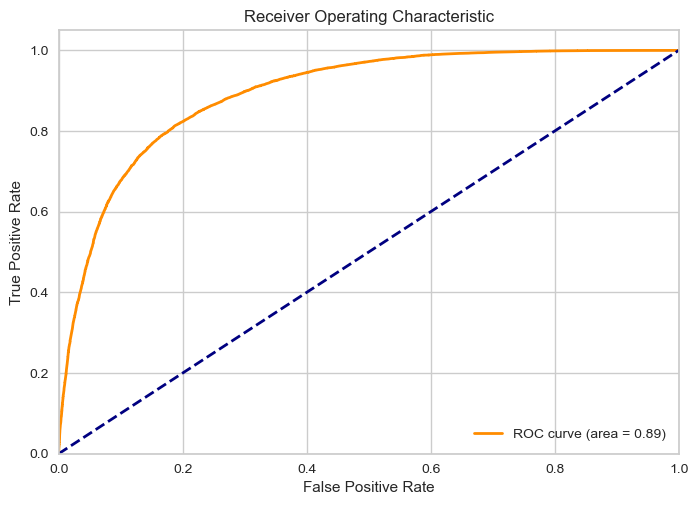



ExtraTreesClassifier(random_state=42)
Precision scores: [0.89149374 0.8920615  0.88776777 0.88626476 0.88940956]
Mean Precision: 0.8893994674
Recall scores: [0.92886615 0.93843869 0.94388513 0.94156487 0.93975904]
Mean Recall: 0.9385027749
F1 scores: [0.90979631 0.91466259 0.9149668  0.91307828 0.91389134]
Mean F1: 0.9132790654
Accuracy scores: [0.90790559 0.9124443  0.91227925 0.91037385 0.91144673]
Mean Accuracy: 0.9108899459
Roc_auc scores: [0.96799245 0.97183931 0.97164808 0.97124083 0.97266289]
Mean Roc_auc: 0.9710767136
Classification Report for ExtraTreesClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     30294
           1       0.89      0.94      0.91     30294

    accuracy                           0.91     60588
   macro avg       0.91      0.91      0.91     60588
weighted avg       0.91      0.91      0.91     60588



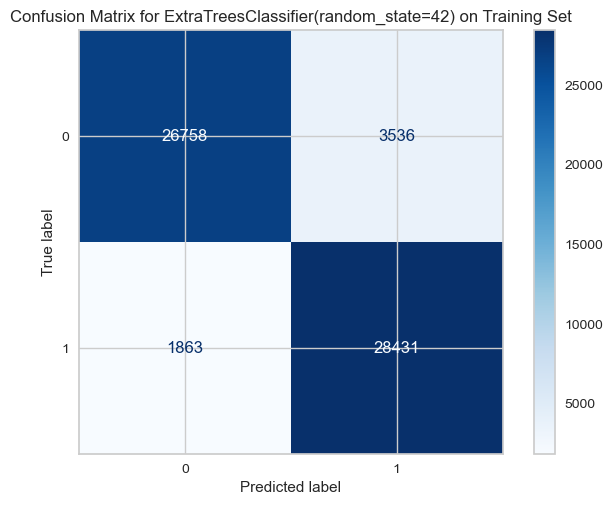

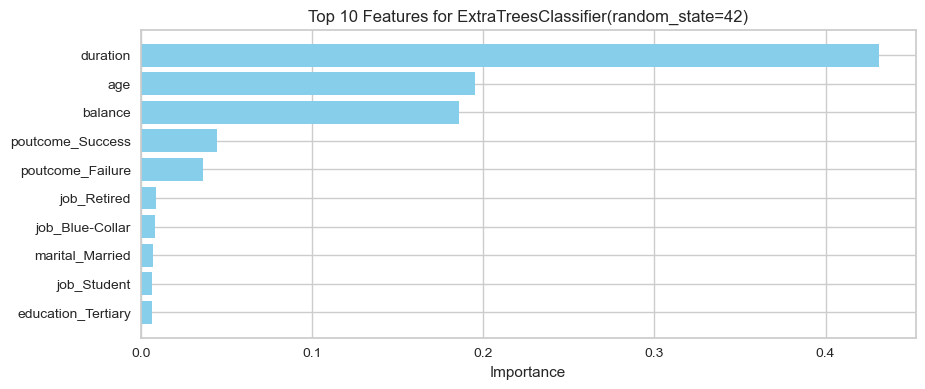

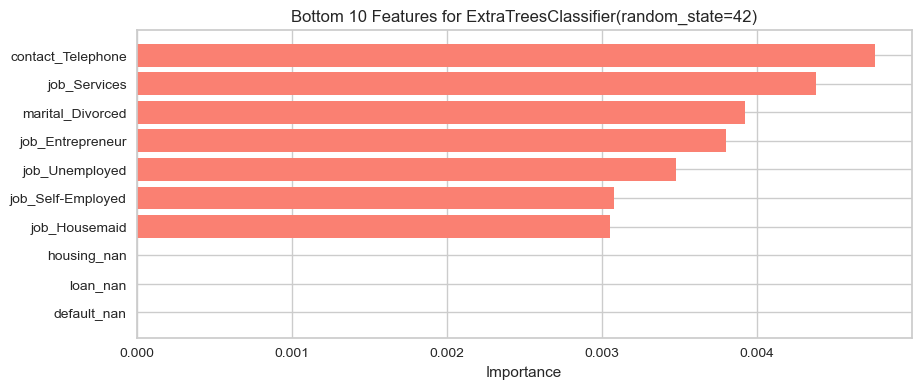

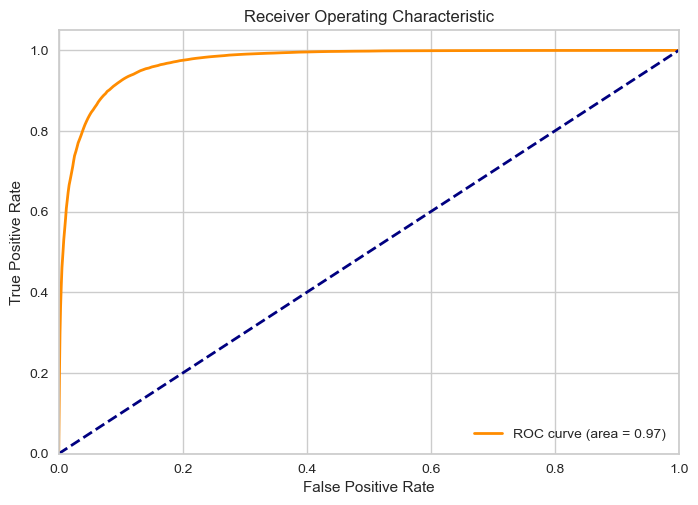

In [32]:
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
}

trained_models = evaluate_models(model_list, X_train, y_train, scoring)

## Top four models

We will focus on 5 models: Random forest, Bagging, Gradient boosting, Extra Trees, as it yields the best results and use precision as the metric.

# Fine-Tune the top four models

## Random forest

In [32]:
def find_best_model(X_train, y_train):
    parameters = {
    'n_estimators' : [100, 200, 300, 500, 800, 1200],
    'max_features' : ['log2', 'sqrt'],
    'max_depth' : [10, 20, 30, 40, 50, 60, None],
    'min_samples_split' : [2, 5, 10, 15, 100],
    'min_samples_leaf' : [1, 2, 5, 10],
}

    rf = RandomForestClassifier(random_state=42)
    grid_search = RandomizedSearchCV(rf, parameters, scoring='precision', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)
    
    rand_res = grid_search.cv_results_
    print('*' * 50)
    for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
        print(mean_score, params)
    
    return best_model

In [33]:
best_model_rand_forest = find_best_model(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60}
**************************************************
0.8332835100960735 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 20}
0.8249693201346612 {'n_estimators': 1200, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 40}
0.8526331390529918 {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}
0.8310699685501817 {'n_estimators': 500, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60}
0.8228714255985586 {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 20}
0.8635688477484619 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_featur

## Bagging

In [33]:
def find_best_model(X_train, y_train):
    parameters = {
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'max_features' : [0.6, 0.8, 1.0]
}

    bag_clf = BaggingClassifier(random_state=42)
    grid_search = RandomizedSearchCV(bag_clf, parameters, scoring='precision', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)
    
    rand_res = grid_search.cv_results_
    print('*' * 50)
    for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
        print(mean_score, params)
    
    return best_model

In [34]:
best_model_bag_clf = find_best_model(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 15, 'max_samples': 1.0, 'max_features': 0.6, 'bootstrap_features': True, 'bootstrap': False}
**************************************************
0.8604680289861985 {'n_estimators': 5, 'max_samples': 0.8, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}
0.9425053621567225 {'n_estimators': 15, 'max_samples': 1.0, 'max_features': 0.6, 'bootstrap_features': False, 'bootstrap': True}
0.8597611975091931 {'n_estimators': 15, 'max_samples': 0.6, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': True}
0.8933236880790266 {'n_estimators': 5, 'max_samples': 0.8, 'max_features': 0.8, 'bootstrap_features': False, 'bootstrap': False}
0.9474849380437855 {'n_estimators': 15, 'max_samples': 1.0, 'max_features': 0.6, 'bootstrap_features': True, 'bootstrap': False}
0.9368886598205929 {'n_estimators': 10, 'max_samples': 0.6, 'max_features': 0.6, 'bootstrap_features': False,

## Gradient boosting

In [36]:
def find_best_model(X_train, y_train):
    parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

    gb_clf = GradientBoostingClassifier(random_state=42)
    grid_search = RandomizedSearchCV(gb_clf, parameters, scoring='precision', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)
    
    rand_res = grid_search.cv_results_
    print('*' * 50)
    for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
        print(mean_score, params)
    
    return best_model

In [37]:
best_model_gradient_boosting = find_best_model(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 500, 'max_depth': 1, 'learning_rate': 1}
**************************************************
0.8095915258182477 {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.01}
0.8142108393518872 {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
0.5464506033685678 {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 10}
0.6864555021923161 {'n_estimators': 5, 'max_depth': 1, 'learning_rate': 0.1}
0.8124047445999606 {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}
0.8183547649965455 {'n_estimators': 5, 'max_depth': 9, 'learning_rate': 0.1}
0.8207849193296283 {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01}
0.868464699759151 {'n_estimators': 500, 'max_depth': 1, 'learning_rate': 1}
0.8177875615400909 {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.1}
0.41425416392673203 {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 100}


## Extra Trees

In [38]:
def find_best_model(X_train, y_train):
    parameters = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

    ext_clf = ExtraTreesClassifier(random_state=42)
    grid_search = RandomizedSearchCV(ext_clf, parameters, scoring='precision', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)
    
    rand_res = grid_search.cv_results_
    print('*' * 50)
    for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
        print(mean_score, params)
    
    return best_model

In [39]:
best_model_extra_trees = find_best_model(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
**************************************************
0.8848816038820294 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
0.8222590982068643 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': None}
0.7894246005666808 {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 5}
0.8615901420625894 {'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
0.8192301131041422 {'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None}
0.8265381600093707 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
0.8254354577599075 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 10}
0.8240704159896269 {'n_estimators

## Top model

Bagging

# Test the performance of the models on the test set

In [35]:
test_copy.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,duration_bins
0,40,Blue-Collar,Married,Secondary,No,580,Yes,No,NaN,16,May,192,1,-1,0,NaN,0,"(100.0, 200.0]"
1,47,Services,Single,Secondary,No,3644,No,No,NaN,9,Jun,83,2,-1,0,NaN,0,"(0.0, 100.0]"
2,25,Student,Single,Tertiary,No,538,Yes,No,Cellular,20,Apr,226,1,-1,0,NaN,0,"(200.0, 300.0]"
3,42,Management,Married,Tertiary,No,1773,No,No,Cellular,9,Apr,311,1,336,1,Failure,0,"(300.0, 400.0]"
4,56,Management,Married,Tertiary,No,217,No,Yes,Cellular,21,Jul,121,2,-1,0,NaN,0,"(100.0, 200.0]"


In [36]:
# Apply the pipeline to the DataFrame
test_pipe_prep = pipeline.fit_transform(test_copy)

In [37]:
# split the test data into X and y (target)
X_test, y_test = test_pipe_prep.loc[:, test_pipe_prep.columns != 'y'], test_pipe_prep['y'].astype('int64')

## Bagging

In [38]:
bagging_predictions = best_model_bag_clf.predict(X_test)
n_correct = sum(bagging_predictions == y_test)
print(n_correct/len(bagging_predictions))

0.8381476083211872


In [42]:
joblib.dump(best_model_bag_clf, "bagging_model.sav")

['bagging_model.sav']